In [1]:
#%matplotlib inline
# NB: per eseguire questo notebook come file Python, commentare l'istruzione "%matplotlib inline" qui sopra e scegliere il menù "File -> Download as -> Python (.py)"
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import *
from scipy.sparse.linalg import *

In [6]:
L=1;
h = 0.01
x = np.arange(0,L+h,h)  # discretizzazione nello spazio
N = len(x); # numero di nodi ed N-1 e' il numero di elementi
dx = np.diff(x)  # contiene la lunghezza dei segmenti della discretizzazione
# numero di modi presi in considerazione
nmodi = 10;  # 10 -> 5 -> 2 -> 1
# posizione iniziale della forzante
load_position = round(N/3.);  # indice del nodo su cui e' applicata
# discretizzazione dei coefficienti :
#
# "u": coefficiente di convezione 
u_c = 0.0
u = u_c + np.asmatrix(np.zeros(N-1)).T
# 
# "c": coefficiente di rigidezza
c_c = 5.0
c = c_c + np.asmatrix(np.zeros(N-1)).T
# 
# "d": coefficiente di densita'
d_c = 1.0
d = d_c + np.asmatrix(np.zeros(N-1)).T
# 
# "f": coefficiente del membro destro (la forzante)
f_c = 0.0
f = f_c + np.asmatrix(np.zeros(N)).T  # "f" e' applicato ai nodi (e quindi varia linearmente sull'elemento)
forzante = lambda t: 30*np.sin(2*np.pi*t*5)  # essendo dipendente dal tempo, f=forzante(t) viene assegnato nel ciclo di simulazione
#
ydn=0;
# condizioni iniziali
y = np.asmatrix(np.zeros(N*2)).T   # [spostamento; velocità]
yndgN = np.asmatrix(np.zeros(N*2)).T
yndgN_m1 = np.zeros((N*2,1))
yndmN_m1 = np.asmatrix(np.zeros(nmodi*2)).T
yndgD = np.asmatrix(np.zeros((N-1)*2)).T
yndgD_m1 = np.asmatrix(np.zeros((N-1)*2)).T
#
Mg = lil_matrix((N,N)); Kg = lil_matrix((N,N)); Fg = np.asmatrix(np.zeros(N)).T 
for i in range(0,N):
  ic=i;  icm1=i-1;
  if i==0:  
    Kg[i,i] = c[ic]/dx[i] - u[ic]/2.  
    Kg[i,i+1] = -c[ic]/dx[i] + u[ic]/2.
  elif i<N-1:  
    Kg[i,i-1] = -c[icm1]/dx[i-1] - u[icm1]/2.
    Kg[i,i] = c[icm1]/dx[i-1] + u[icm1]/2. + c[ic]/dx[i] - u[ic]/2.
    Kg[i,i+1] = -c[ic]/dx[i] + u[ic]/2.
  else:  
    Kg[i,i-1] = -c[icm1]/dx[i-1] - u[icm1]/2.
    Kg[i,i] = c[icm1]/dx[i-1] + u[icm1]/2.
  #endif
  if i==0: 
    Mg[i,i] = d[ic]*dx[i]/3.  
    Mg[i,i+1] = d[ic]*dx[i]/6.
  elif i<N-1: 
    Mg[i,i-1] = d[icm1]*dx[i-1]/6.
    Mg[i,i] = d[icm1]*dx[i-1]/3. + d[ic]*dx[i]/3.
    Mg[i,i+1] = d[ic]*dx[i]/6.
  else: 
    Mg[i,i-1] = d[icm1]*dx[i-1]/6.
    Mg[i,i] = d[icm1]*dx[i-1]/3.
  #endif
  if i==0: 
    Fg[i] = f[1]*dx[i]/3. + f[2]*dx[i]/6.
  elif i<N-1: 
    Fg[i] = f[i-1]*dx[i-1]/6. + f[i]*(dx[i-1]+dx[i])/3. + f[i+1]*dx[i]/6.
  else:       
    Fg[i] = f[i-1]*dx[i-1]/6. + f[i]*dx[i-1]/3.
  #endif  
#endfor
iMg = np.linalg.inv(Mg.todense());
invMxK = iMg*Kg;
invMxF = iMg*Fg;
FDiriN = 0;
Bg = lil_matrix((N,N-1));  
for i in range(0,N-1):  
  Bg[i,i]=1.0; 
#endfor

In [7]:
D,V = np.linalg.eig(invMxK)
I = np.argsort(D)
D = D[I]
V = V[:,I]

In [8]:
### discretizzazione nel tempo
if d_c==0:  
  T = dt; # cosi` finisce in una iterazione e si risole il problema stazionario
else:
  T = 2;
#endif
AsN = np.asmatrix(np.zeros((2*N,2*N)))
AsN[0:N,N:2*N] = np.eye(N)
AsN[N:2*N,0:N] = -invMxK
BsN = np.asmatrix( np.zeros((2*N,1)) )
BsN[N:2*N,0] = invMxF+FDiriN
#
V = np.asmatrix(V[:,0:nmodi])  
Fm = V.T @ Fg 
Mm = V.T @ Mg @ V  
Km = V.T @ Kg @ V
iMm = np.linalg.inv(Mm)
invMmxKm = iMm @ Km
invMmxFm = iMm @ Fm
AmN = np.asmatrix(np.zeros((2*nmodi,2*nmodi)))
AmN[0:nmodi,nmodi:2*nmodi] = np.eye(nmodi)
AmN[nmodi:2*nmodi,0:nmodi] = -invMmxKm
BmN = np.asmatrix( np.zeros((2*nmodi,1)) )
BmN[nmodi:2*nmodi,0] = invMmxFm
# creo le matrici per Eulero implicito:
dt = 0.01
BN = np.eye(N*2) - dt*AsN
cN = dt*BsN
BmodaleN = np.eye(nmodi*2) - dt*AmN
cmN = dt*BmN

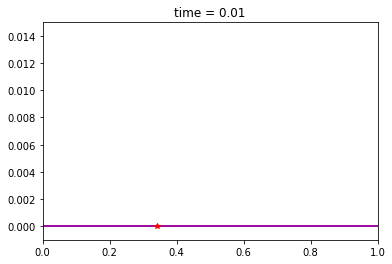

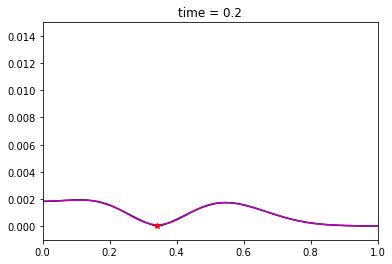

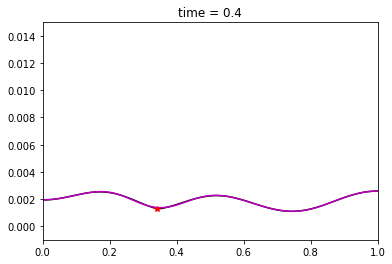

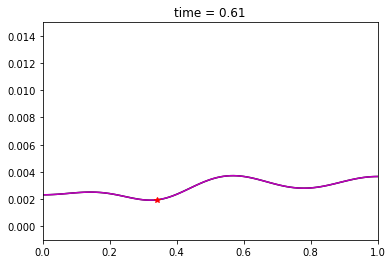

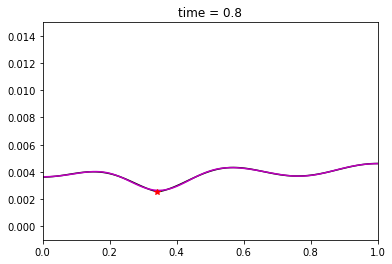

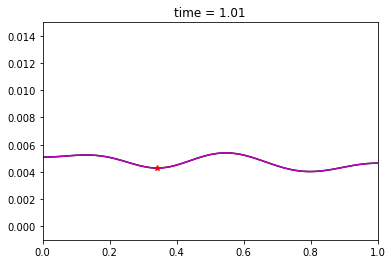

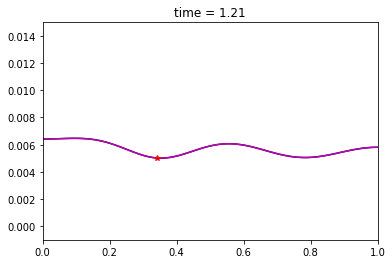

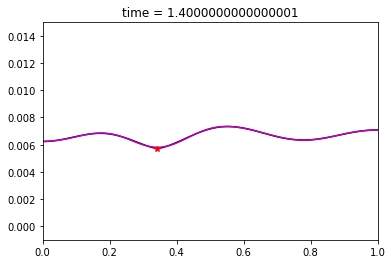

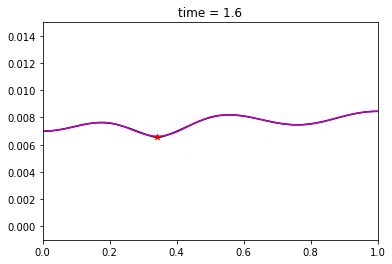

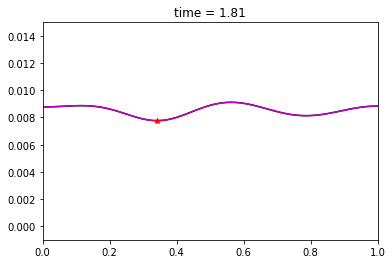

In [9]:
it = 0
nframes = 10.
dtf = T/nframes;
serie_t = np.arange(dt,T+dt,dt);    len_serie_t=len(serie_t);
spost_ricev = np.zeros(len_serie_t)
load_exact_position = load_position;
for t in serie_t:
  it = it+1
  #print("cN = ", cN.T)
  #print("yndgN_m1 = ", yndgN_m1.T)
  #b = yndgN_m1 + cN
  #print("b = ", b.T)
  yndgN = np.linalg.solve(BN, yndgN_m1 + cN)
  #print("yndgN = ", yndgN.T)
  # NB: la matrice "BN" sarebbe sparsa: se avessimo usato per lei la rappresentazione sparsa, avremmo risolto il sistema con "spsolve(BN, yndgN_m1+cN)"
  yndmN = np.linalg.solve(BmodaleN, yndmN_m1+cmN)
  syN = yndgN[0:N]
  smyN = yndmN[0:nmodi]
  yndgN_m1 = yndgN.copy()
  yndmN_m1 = yndmN.copy()
  # visualizzazione dei risultati
  if (t % dtf)<=dt:
    plt.figure(it);
    plt.plot(x,syN,'k-')
    plt.plot(x,V@smyN,'m-');
    plt.plot(load_position*dx[0],syN[load_position],'r*'); 
    plt.axis([0., L, -0.001, 0.015])
    plt.title('time = ' + str(t))
    plt.show()
  #endif
  if t>0.:
    # evoluzione della forzante
    load_intensity = forzante(t)
    Fg = np.asmatrix(np.zeros(Fg.shape[0])).T
    Fg[load_position+1-1] = load_intensity*dx[0]/3.
    Fg[load_position+2-1] = load_intensity*dx[0]/6.
    invMxF = iMg@Fg
    Fm = V.T@Fg 
    invMmxFm = iMm@Fm
  #endif
  BsN[N:2*N,0:N] = invMxF+FDiriN
  cN = dt*BsN
  BmN[nmodi:2*nmodi,0:nmodi] = invMmxFm
  cmN = dt*BmN
#endfor